<table>
    <tr>
        <td><img src="https://s3.amazonaws.com/media-p.slid.es/uploads/1485763/images/9060062/Header.png" width="300"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="font-size:200%;color:blue;text-align:center">    <FONT COLOR="blue">  DBSCAN </p> Mean Shift</p> Clustering   </FONT>         </h1></td>         
        <td>
            <tp><p style="font-size:99%;text-align:center">Diplomado Ciencia de Datos </p></tp>
            <tp><p style="font-size:115%;text-align:center">2025-
            1</p></tp>
            <tp><p style="font-size:115%;text-align:center">Prof. Fabián Sánchez</p></tp>
        </td>
    </tr>
</table>

In [ ]:
%%html
<center><marquee style='width: 60%; color: red'><b>✌ ¡Hola a todos y a todas! Un saludo... Bienvenidos a la clase de DBSCAN✌ </b></marquee><center>

# <FONT SIZE=5 COLOR="purple"> 1. Definición de función para trabajo de DBSCAN </FONT>

Vamos a importar las librerías y definir unas funciones para el trabajo de este cuaderno.

In [ ]:
# Manejo de dataframes
import pandas as pd
import numpy  as np

# Librería de gráficas
import matplotlib.pyplot  as plt
import seaborn            as sns
import plotly.express     as px

# configuración gráfica para todo el notebook
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)

# Librería de skleann
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import DBSCAN
from sklearn.cluster       import MeanShift, estimate_bandwidth
from sklearn.cluster       import KMeans

# ignorar advertencias
import warnings
warnings.filterwarnings("ignore")

In [ ]:
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [ ]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [ ]:
def cluster_biplot(pca, dataframe, col_clusters, comp1=1, comp2=2, size_text=8 ):
  """
    Esta función construye el biplot de un PCA y muestra los cluster en el plano factorial.
    Input:  pca: Objeto pca que se usará para plotear los clusters.
            dataframe: pandas-DataFrame con el que se realizó el pca.
            col_cluster: Lista o pd.series con las etiquetas del asiganadas vía el método de cluster.
            comp1 = Componente en el eje x.
            comp2 = Compomente en el eje y
            size_text (int +): Tamáno del texto para buscar evitar overlapping.
    Output: Biplot con los clusters.
  """
  ## Trabajo con pca y dataframe.
  comp_1, comp_2 = str(comp1), str(comp2) ## Strings de las compomentes a plotear.
  scaler, length = StandardScaler(), len(pca.explained_variance_)
  percent_var = pca.explained_variance_ratio_*100
  scaler.fit(dataframe)
  X_scaled = scaler.transform(dataframe)
  ##
  tmp = dataframe.copy()
  if tmp.index.name == None:        ## En caso que el DataFrame no tenga nombre para el índice.
    tmp.index.name = "Indice"
  pca_trans = pd.DataFrame(pca.transform(X_scaled), index = tmp.index,
                           columns = ["PC" + str(comp) for comp in range(1, length+1)])
  text_list = [pca_trans.index.name + ": {}".format(pca_trans.index[i]) for i in range(0,len(tmp))]

  features, tmp["cluster"]  = tmp.columns, col_clusters
  tmp["cluster"] = tmp["cluster"].astype("category")
  ##
  fig = px.scatter(tmp, x = pca_trans[f"PC{comp_1}"], y = pca_trans[f"PC{comp_2}"],color = "cluster",
                   text = tmp.index, hover_name=tmp.index, template = "plotly_white",symbol="cluster")
  ## Personalización plot
  fig.add_hline(y = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width = 0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(pca_trans[f"PC{comp_1}"]),
                    textfont_size = size_text,)
  fig.update_layout(title = "PCA-CLUSTER Biplot.")
  fig.update_xaxes(range = [min(pca_trans[f"PC{comp_1}"] - 0.35), max(pca_trans[f"PC{comp_1}"]) + 0.35],
                   title_text = "Dim "+ comp_1 + " ({:.2f}%)".format(percent_var[comp1-1]))
  fig.update_yaxes(range = [min(pca_trans[f"PC{comp_2}"] - 0.35), max(pca_trans[f"PC{comp_2}"]) + 0.35],
                   title_text = "Dim "+ comp_2+ " ({:.2f}%)".format(percent_var[comp2-1]))
  fig.show()

  return None

In [ ]:
def knn_plot_dbscan(df, neighbor = 2):
  """
      Función que genera el plot para buscar seleccionar el valor de eps, en un clustering DBSCAN
      en sklearn.
      Input: pd.DataFrame con quien se ajustará el clustering DBSCAN
             neighbor (int >1): Numéro de vecinos cercanos deseados (puede usar 2*#_de_features)
      Output: None
  """
  from sklearn.neighbors import NearestNeighbors
  neigh = NearestNeighbors(n_neighbors=neighbor)
  nbrs = neigh.fit(df)
  distances, indices = nbrs.kneighbors(df)
  distances = distances[:,1:]
  distances = np.sort(np.mean(distances, axis = 1))
  fig = px.line(x = range(distances.shape[0]),y=distances, template="plotly_white")
  fig.update_xaxes(title_text = "Points (sample) sorted by distance")
  fig.update_yaxes(title_text = "2-NN distance")
  fig.show()

  return None

# <FONT SIZE=5 COLOR="purple"> 2. Explicación conceptual del método DBSCAN (Density-based spatial clustering of applications with noise)</FONT>

- El método de DBSCAN es un algoritmo de **clustering**.

- DBSCAN viene del inglés *Density-Based Spatial Clustering of Applications with Noise* ("clustering con ruido basado en la densidad") es un algoritmo de agrupamiento basado en densidad, lo que significa que forma grupos (clústeres) en base a la cantidad de puntos que hay en una región.

- Es decir, el algoritmo busca identificar regiones "pobladas", es decir donde muchos registros están muy juntos, estas regiones se conocen como  ***regiones densas en el espacio de datos.***

- La idea básica detrás de este enfoque de clustering se deriva de un método humano de agrupamiento intuitivo. Es decir, el cerebro humano puede identificar clusters observando los puntos que están cerca y además dejando sin ninguna asignación a registros que están aíslados (ruído).

- ***los clusters son regiones densas en el espacio de datos, separadas por regiones de menor densidad de puntos***. El algoritmo DBSCAN se basa en esta noción intuitiva de "clusters" y "ruido". La idea clave es que para cada punto de un cluster, la vecindad tiene que contener al menos un número mínimo de puntos.

**Algunas ventajas de DBSCAN**

- No es necesario indicar el número de clústeres (como sí en K-means).

- Puede encontrar clústeres de forma arbitraria (no solo esféricos).

- Detecta "ruido" o valores atípicos automáticamente.

- Muy útil cuando hay diferencias de densidad en los datos.

Sin embargo, es un poco más lento que *k-means* (depende los datos)

## <FONT SIZE=5 COLOR="blue"> 2.1 Definición de Conceptos </FONT>

- La idea detrás de DBSCAN es que ***los clusters forman  regiones  densas de datos***, separadas por regiones que están relativamente vacías. Los puntos que están dentro de una región densa se denominan _core points_ (core points).

- Hay dos parámetros importantes en DBSCAN:

  - *min_samples*: define el número mínimo de puntos en una vecindad. Entiéndae por vecindad a una bolita (círculo de un determinado tamaño)
  
  - *eps:* Valor dado que determina el tamaño de la vecindad ("círculo").
  
  - Un punto $p$ es un **core_point** si, dentro de un radio $\epsilon$, hay al menos *min_samples* puntos (incluyendo al propio $p$).
    
    Si hay al menos *min_samples* puntos dentro de una distancia *eps* ($ϵ$-vecindad), ese punto se clasifica como un _core point_.  
    

El algoritmo funciona eligiendo un punto arbitrario para comenzar. Luego encuentra ***todos los puntos con distancia menor o igual a la dada en *eps* (definición de $ϵ$-vecindad)***.

 - Si hay menos de *min_samples* puntos dentro de la distancia *eps* del punto de partida, ***este punto se etiqueta como ruido,  lo que significa que no pertenece a ningún cluster (por ahora)***.

 - Si hay más de *min_samples* puntos dentro de una distancia *eps*, el punto se etiqueta como _core point_ y se le asigna una nueva etiqueta de cluster. Luego, se visitan todos los vecinos ("viaja" por la $ϵ$-vecindad) del punto, a estos puntos se les asigna la nueva etiqueta de cluster que se acaba de crear.

 - Si son _core points_, sus vecinos son visitados a su vez, y así sucesivamente. El cluster crece hasta que no hay más _core points_ a una distancia *eps* del cluster.

Después se elige otro punto que aún no ha sido visitado, y se sigue el mismo procedimiento anterior.

**Precisemos algunos concpetos**

- ***Core point:*** Una observación que tiene en su $ϵ$-vecindad un número de observaciones vecinas igual o mayor que *min_sample*.

- ***Boder point:*** Una observación que no satisface el número mínimo de observaciones vecinas para ser _core point_, pero pertenece a la $ϵ$-vecindad de otra observación que si es _core point_.

- ***Noise u outlier:*** Una observación que no es _core point_ ni _border point_.

<br>
<center><img src="https://github.com/Fabian830348/cursos/blob/45a8412d71ab5d325511f484fc1b576fdf9f3d15/dbscan1.png?raw=true" alt="centered image" width="500" height="400"></center><center><figcaption> <FONT SIZE=1 COLOR="black"> Fuente: https://vevesta.substack.com/p/beginners-guide-to-dbscan-clustering  </FONT> <figcaption></center>

<center>

***ALGORITMO DBSCAN***

<img src="https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif" alt="drawing" width="600" height = "300"/>Fuente: https://miro.medium.com  </FONT> <figcaption></center>





Basados en las tres categorías anteriores se pueden definir tres niveles de conectividad entre observaciones:

- ***Directamente alcanzable (direct density reachable):*** Una observación $B$ es directamente alcanzable desde otra observación $A$ si $B$ forma parte de la $ϵ$-vecindad de $A$ y $A$ es un _core point_. Por definición, las observaciones solo pueden ser directamente alcanzables desde un _core point_.

- ***Alcanzable (density reachable):*** Una observación $A$ es alcanzable desde otra observación $B$ si existe una secuencia de _core points_ que van desde $B$ a $A$.

- ***Densamente conectadas (density conected):*** Dos observaciones $B$ y $C$ están densamente conectadas si existe una observación $A$ que es un _core point_, tal que $B$ y $C$ son alcanzables desde $A$.

<br>
<center><img src="https://github.com/Fabian830348/cursos/blob/12d6e19647c20d57467d8c427fe90e0f35b7ca05/dbscan2.png?raw=true" alt="centered image" width="500" height="350"></center><center><figcaption> <FONT SIZE=1 COLOR="black"> Fuente: wikipedia </FONT> <figcaption></center>

La imagen anterior muestra las conexiones existentes entre un conjunto de observaciones con *min_samples=4*.

La observación $A$ y el resto de observaciones marcadas con rojo son core points, ya que todas ellas contienen al menos 4 observaciones vecinas (incluyéndose a ellas mismas) en su $\epsilon$-vecindad.

Como todas son alcanzables entre ellas, forman un cluster. Las observaciones $B$ y $C$ no son core points, pero son densamente alcanzables desde $A$ y densamente conectados con A, y por lo tanto pertenecen al mismo clúster. La observación $N$ no es ni _core point_ ni es directamente alcanzable, por lo tanto se considera como noise (ruido)

# <FONT SIZE=5 COLOR="purple"> 3. Algoritmo DBSCAN </FONT>

1. Para cada observación $x_i$ calcular la distancia entre ella y el resto de observaciones. Si en su $ϵ$-vecindad hay un número de observaciones ***mayor o igual*** a `min_sample` marcar la observación como _core point_, de lo contrario marcarla como visitada.

2. Para cada observación $x_i$ marcada como _core point_, si todavía no ha sido asignada a ningún cluster, crear uno nuevo y asignarla a él. Encontrar recursivamente ***todas las observaciones densamente conectadas a ella*** y asignarlas al mismo cluster.

3. Iterar el mismo proceso para todas las observaciones que no hayan sido visitadas.

4. Aquellas observaciones que tras haber sido visitadas no pertenecen a ningún cluster se marcan como outliers.



***NOTA:*** Como resultado, todo cluster cumple dos propiedades:

1. Todos los puntos que forman parte de un mismo cluster están ***densamente conectados entre ellos.***

2. Si una observación $A$ es ***densamente alcanzable desde cualquier otra observación*** de un cluster, entonces $A$ también pertenece al cluster.

## <FONT SIZE=5 COLOR="blue"> 3.1 Selección de Parámetros </FONT>

Como ocurre en muchas otras técnicas estadísticas, en DBSCAN no existe una forma única y exacta de encontrar el valor adecuado de epsilon (*eps*) y *min_samples*. A modo orientativo se pueden seguir las siguientes condiciones:

**min_samples**

 - Cuán mayor sea el tamaño del conjunto de datos, mayor debe ser el valor mínimo de observaciones vecinas.
 - Se recomienda que no sea inferior a 3.
 - Si los datos contienen niveles altos de ruido, aumentar *min_samples* ayudará a la creación de clusters significativos menos influenciados por outliers.

**eps**

 - Una buena forma de escoger este valor consiste en calcular las $k$-distancias vecinas más cercanas. Seguido, calcular el promedio de esas distancias.
 - El valor de $k$ será especificado por el usuario y corresponde a *min_samples*. Luego, estas $k$-distancias se trazan en orden ascendente. El objetivo es determinar la *rodilla*, que corresponde al parámetro *eps* óptimo.
 - Una rodilla corresponde a un umbral donde se produce un cambio brusco a lo largo de la curva de las $k$ distancias.
 - Si el valor de *eps* escogido es muy pequeño, una proporción alta de las observaciones no se asignarán a ningún cluster.
 - Si el valor de *eps *es demasiado grande, la mayoría de observaciones se agruparán en un único cluster.

## <FONT SIZE=5 COLOR="purple"> 3.2 Ventajas y Desventajas de DBSCAN </FONT>

***Ventajas de DBSCAN.***

 - A diferencia de $K$-means, DBSCAN no requiere que el usuario especifique el número de clusters a generar.
 - DBSCAN es independiente de la forma que tengan los clusters, no tienen por qué ser circulares.
 - DBSCAN puede identificar outliers, por lo que los clusters generados no son influenciados por ellos.

***Desventajas de DBSCAN.***

 - No es un método totalmente determinístico: los border points que son alcanzables desde más de un cluster pueden asignarse a uno u otro dependiendo del orden en el que se procesen los datos.
 - No genera buenos resultados cuando la densidad de los grupos es muy distinta, ya que no es posible encontrar los parámetros `eps` y `min_samples` que sirvan para todos a la vez.


# <FONT SIZE=5 COLOR="purple"> 4. Ejemplo 1: USArrests </FONT>



In [ ]:
USArrests = pd.read_csv("https://raw.githubusercontent.com/Fabian830348/Bases_Datos/refs/heads/master/USArrests.csv", index_col=0)
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Es importante escalar la información ya que vamos a trabajar con distancias.

In [ ]:
# Estandarizamos los datos.
scaler = StandardScaler()
scaler.fit(USArrests)
# veamos el dataframe
df = pd.DataFrame(scaler.transform(USArrests), columns = USArrests.columns, index = USArrests.index)
df.head(6)

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814
Colorado,0.025976,0.402909,0.869548,1.883901


Revisamos la gráfica *knn_plot* que permite determinar los cambios en el promedio de distancia y obtener el $epsilon$.

In [ ]:
knn_plot_dbscan(df,neighbor=8)

Se puede observar en la gráfica que $epsilon$ puede estar más o menos alrededor de 1.4 o 1.5.

In [ ]:
from sklearn.cluster import DBSCAN
# Definimos DBSCAN y los parámetros
clustering = DBSCAN(eps=1.4, min_samples = 8)
# entrebamos el modelo
clustering.fit(df)
# veamos las etiquetas
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 2,  8, 10, 30]))

Veamos una visualización en dos dimensiones

In [ ]:
# Ajustamos un PCA
pca = PCA(n_components=0.99)
pca.fit(df)
pca_array = pca.transform(df)

In [ ]:
# Plot con 2 clusters.
cluster_biplot(pca,
               USArrests,
               clustering.labels_,
               size_text=5)

Revisamos los grupos que se asignaron

In [ ]:
# Comparando clusters.
df_Cluster = USArrests.copy()
df_Cluster["cluster"] = clustering.labels_
df_Cluster.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,-1
Arizona,8.1,294,80,31.0,1
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,1


Quitamos los puntos del clúster -1, ya que son aislados

In [ ]:
df_cluster_plot = df_Cluster[df_Cluster["cluster"] !=-1]
df_cluster_plot["cluster"] = df_cluster_plot["cluster"].astype("category")

Gráficamos los Boxplots

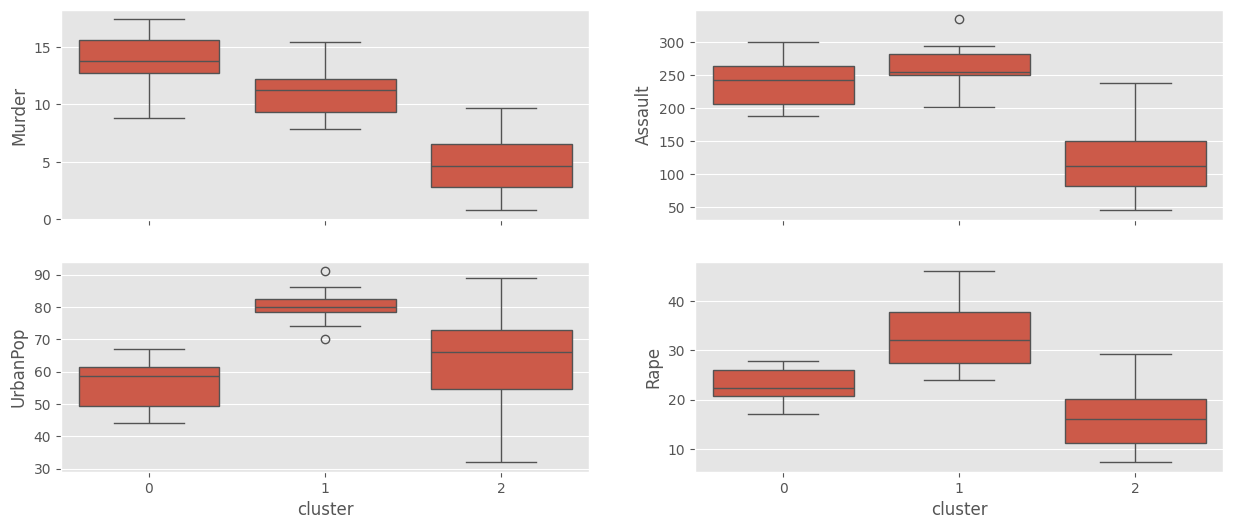

In [ ]:
# Box-plots
fig, axes = plt.subplots(2,2, sharex=True)
#
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Murder", ax = axes[0,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Assault", ax = axes[0,1])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "UrbanPop", ax = axes[1,0])
sns.boxplot(data=df_cluster_plot, x = "cluster", y = "Rape", ax = axes[1,1])
plt.show()

Se puede observar diferencias entre las agrupaciones de acuerdo con las características de cada una de las variable.

# <FONT SIZE=5 COLOR="purple"> 5. Otros ejemplos </FONT>

Uno de los desafíos en la aplicación de algoritmos de agrupamiento es que es muy difícil evaluar qué tan bien funcionó un algoritmo y comparar los resultados entre diferentes algoritmos.

## <FONT SIZE=5 COLOR="purple"> 5.1 Ejemplo: medias lunas </FONT>

In [ ]:
# importamos las librerías donde están los datos
from sklearn.datasets import make_moons
# cargamos los datos
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
X = pd.DataFrame(X, columns = ["feature_1","feature_2"])
X.head()

,feature_1,feature_2
0,2.021001,0.490179
1,1.678201,-0.201987
2,-0.282245,0.858785
3,-0.021440,0.176281
4,0.504842,-0.391043


In [ ]:
# escalamos los datos
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
# construimos el dataframe
df_scaled = pd.DataFrame(X_scaled, columns = ["feature_1","feature_2"])
df_scaled.head()

,feature_1,feature_2
0,1.750819,0.483940
1,1.356064,-0.907069
2,-0.901504,1.224707
3,-0.601172,-0.146884
4,0.004873,-1.287005


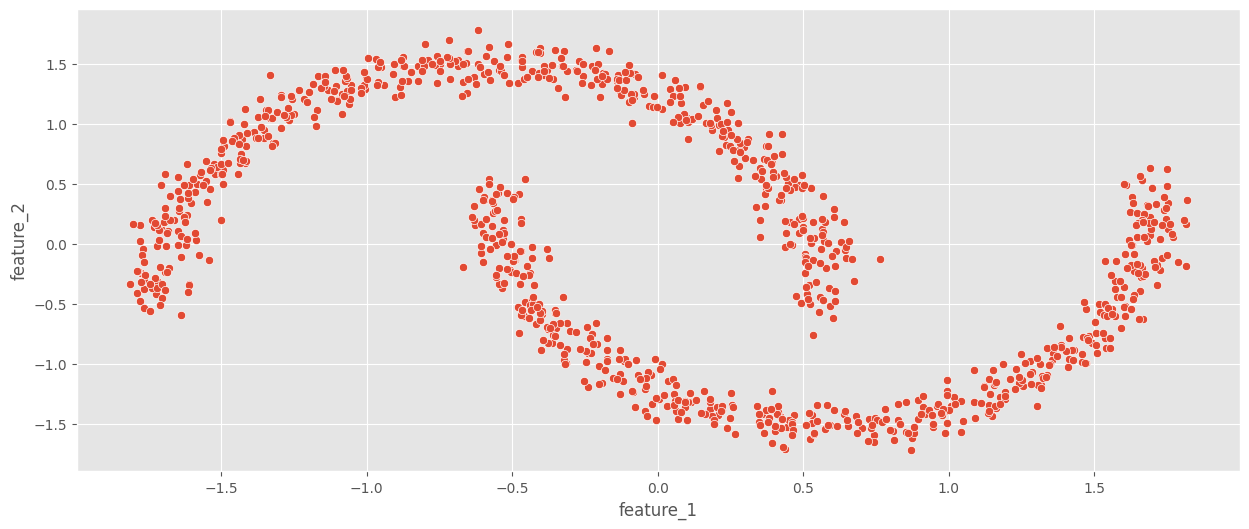

In [ ]:
# Gráficamos la nube de puntos original.
sns.scatterplot(data = df_scaled, x="feature_1", y = "feature_2")
plt.show()

Vamos a aplicar, k-means

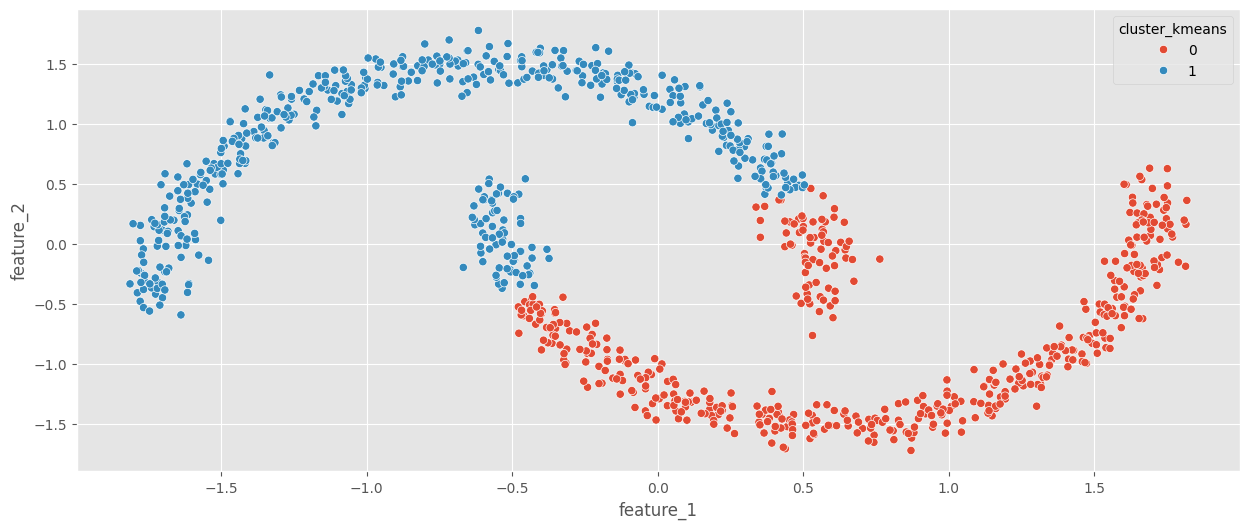

In [ ]:
# Con k-means con dos clusters
df_kmeans = df_scaled.copy()
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_kmeans)
df_kmeans["cluster_kmeans"] = kmeans.labels_
# gráfico
sns.scatterplot(data = df_kmeans, x = "feature_1", y = "feature_2", hue = "cluster_kmeans")
plt.show()

Ahora, con DBSCAN

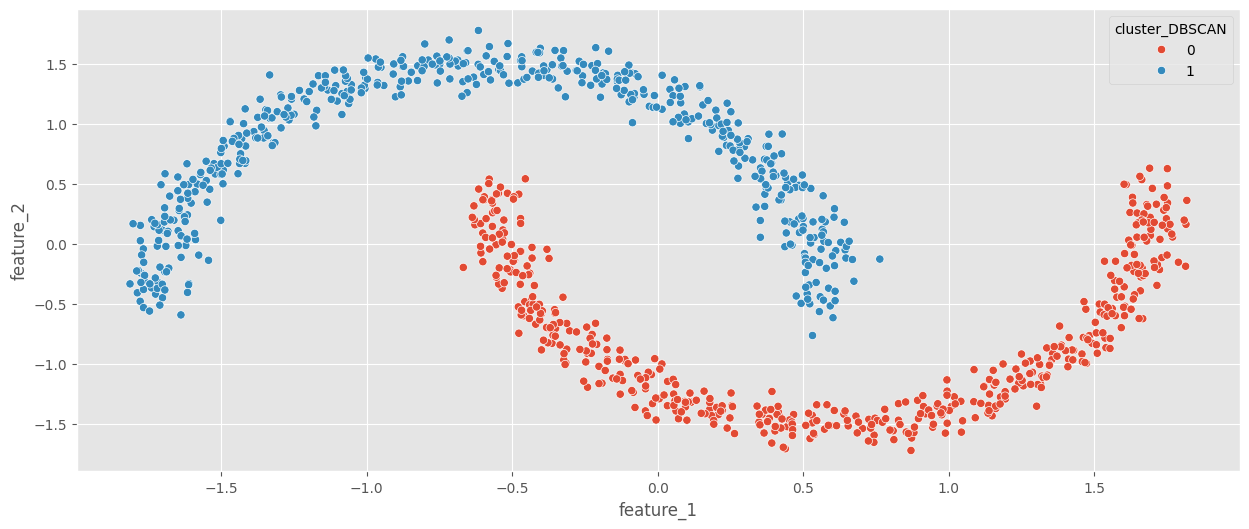

In [ ]:
# Con DBSCAN
df_dbscan = df_scaled.copy()
dbscan = DBSCAN(eps = 0.2, min_samples=10)
dbscan.fit(df_dbscan)
df_dbscan["cluster_DBSCAN"] = dbscan.labels_
# gráfico
sns.scatterplot(data = df_dbscan, x = "feature_1", y = "feature_2", hue = "cluster_DBSCAN")
plt.show()

Vamos a hacer el gráfico interactivo

In [ ]:
pip install ipywidgets matplotlib seaborn scikit-learn

In [ ]:
# gráfico interactivo
from ipywidgets  import interact, FloatSlider, IntSlider

X, _ = make_moons(n_samples=1000, noise=0.05,random_state=0)
df = pd.DataFrame(X, columns=["feature_1", "feature_2"])

# Escalar los datos
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Función interactiva
def plot_dbscan(eps, min_samples):
    df_dbscan = df_scaled.copy()

    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(df_dbscan)
    df_dbscan["cluster_DBSCAN"] = dbscan.labels_

    # Gráfico
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_dbscan, x="feature_1", y="feature_2", hue="cluster_DBSCAN", palette="tab10")
    plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# Interfaz interactiva
interact(plot_dbscan,
         eps=FloatSlider(value=0.3, min=0.05, max=1.0, step=0.05, description='eps'),
         min_samples=IntSlider(value=5, min=1, max=20, step=1, description='min_samples'))

interactive(children=(FloatSlider(value=0.3, description='eps', max=1.0, min=0.05, step=0.05), IntSlider(value…

<function __main__.plot_dbscan(eps, min_samples)>

Cuando se aplican algoritmos de clustering, por lo general no existe una "verdad" básica con la cual comparar los resultados. Hay métricas de puntuación para el clustering como el coeficiente de silueta. Este coeficiente calcula la compacidad de un clúster, donde un valor más alto es mejor, con una puntuación perfecta de 1. Si bien los clústeres compactos son buenos, la compacidad no trabaja bien en formas complejas
formas.

In [ ]:
from sklearn.metrics import silhouette_score
algoritmos = [kmeans, dbscan]
for algoritmo in algoritmos:
  clusters = algoritmo.fit_predict(X_scaled)
  a = silhouette_score(X_scaled, clusters)
  print("Algoritmo:",algoritmo,"---> silhouette_score:",a)

Algoritmo: KMeans(n_clusters=2) ---> silhouette_score: 0.49877630129450223
Algoritmo: DBSCAN(eps=0.2, min_samples=10) ---> silhouette_score: 0.3915969903000845


$K$-means obtiene la puntuación de silueta más alta, aunque se prefiere el resultado obtenido por DBSCAN.

## ***Referencias:***

1. _Multivariate Analysis I. Kassambara A. Disponible en: http://www.sthda.com/english/_

2. _Introduction to machine learning with Python: a guide for data scientists. Müller, A. C., & Guido, S. (2016).  O'Reilly Media, Inc._

# <FONT SIZE=5 COLOR="purple"> 6. Algoritmo Mean Shift </FONT>

- **Mean Shift** es un algoritmo de clustering basado en densidad, que no requiere especificar el número de clústeres.

- Se basa en la idea de mover los puntos de datos hacia las zonas de mayor densidad local, como si cada punto "escalara" una colina de densidad hasta llegar a la cima.

**Ideas general de Mean Shift**

 - Paso 1: **Se elije un punto inicial** (puede ser cualquier punto del conjunto de datos)

 - Paso 2: **Definir una ventana (kernel):** Dibujamos una ventana circular (o de cualquier forma, pero por defecto es gaussiana o plana) de radio ***bandwidth*** alrededor del punto. Luego, se identifican todos los puntos vecinos dentro de esa ventana.

 - Paso 3: **Calcular el "mean" (promedio)** Calculamos el centro de masa (promedio) de esos puntos vecinos. Este valor (punto promedio) representa el centro de densidad local.

 $$x' = \dfrac{\sum_{x_i \in V(x)} K(x_i-x). x_i}{\sum_{x_i \in V(x)} K(x_i-x)}$$

 En este caso, $K$ es un kernel Gaussiano, Uniforme, etc. $V(x)$ son los puntos de la vecindad.

 - Paso 4: **Shift (desplazamiento)** Movemos el punto actual hacia ese centro.

  Este proceso se repite hasta que el punto ya no se mueve significativamente (convergencia).

 - Paso 5: **Agrupar puntos que convergen al mismo "modo"**: Todos los puntos que convergen al mismo centro de densidad (modo) son considerados parte del mismo clúster.



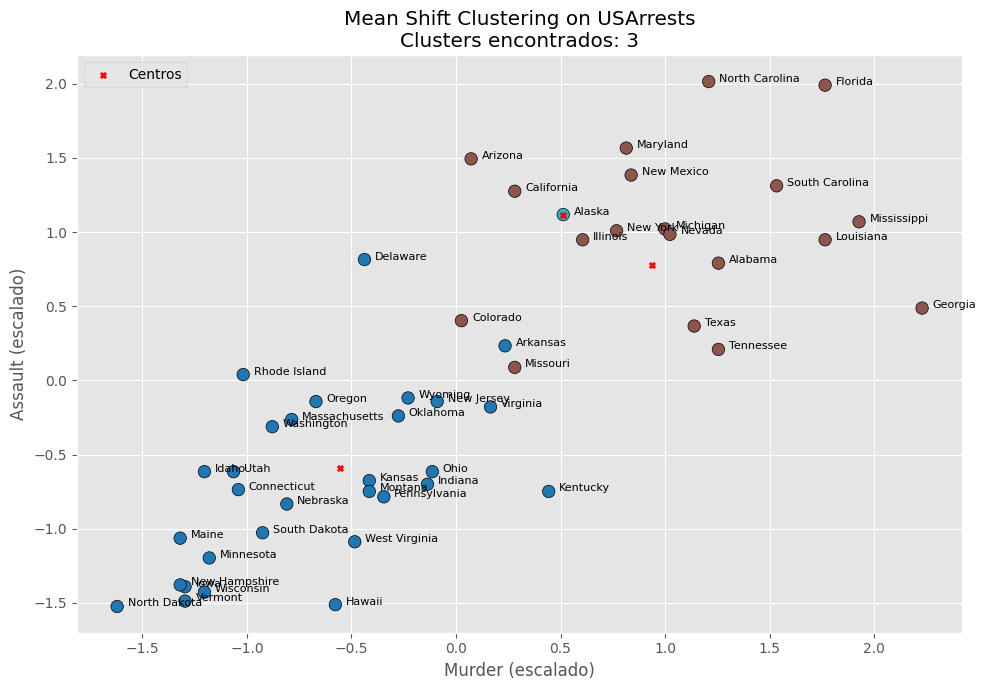

In [ ]:
# 1. Cargar el dataset USArrests
USArrests = pd.read_csv("https://raw.githubusercontent.com/Fabian830348/Bases_Datos/refs/heads/master/USArrests.csv", index_col=0)

# 2. Escalar los datos
scaler = StandardScaler()
USArrests_scaled = scaler.fit_transform(USArrests)

# 3. Estimar el bandwidth y aplicar Mean Shift
bandwidth = estimate_bandwidth(USArrests_scaled,    # datos escalados
                               quantile=0.2)        # aprox el número de vecinos que tenga la vecindad.
ms = MeanShift(bandwidth=bandwidth,
               bin_seeding=True)                    # una forma particular de elegir los puntos de inicio (centros de la rejillas)
ms.fit(USArrests_scaled)
labels = ms.labels_
centers = ms.cluster_centers_

# 4. Añadir resultados al DataFrame original
USArrests['Cluster'] = labels

# 5. Visualización (usamos solo 2 primeras features para graficar)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(USArrests_scaled[:, 0],    # variable 1
                      USArrests_scaled[:, 1],    # variable 2
                      c=labels,                  # labels
                      cmap='tab10',              # colores paleta
                      s=80,                      # tamaño del punto
                      edgecolor='k')             # bordes negros

# Etiquetas de estado
for i, state in enumerate(USArrests.index):
    plt.text(USArrests_scaled[i, 0]+0.05,
             USArrests_scaled[i, 1],
             state,
             fontsize=8)

# Marcar centros de clústeres
plt.scatter(centers[:, 0],
            centers[:, 1],
            c='red',
            s=20,
            marker='X',
            label='Centros')

plt.title(f'Mean Shift Clustering on USArrests\nClusters encontrados: {len(np.unique(labels))}')
plt.xlabel('Murder (escalado)')
plt.ylabel('Assault (escalado)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Etiquetas únicas:", np.unique(labels))
print("Centros encontrados:", len(cluster_centers))

Etiquetas únicas: [0 1 2]
Centros encontrados: 3


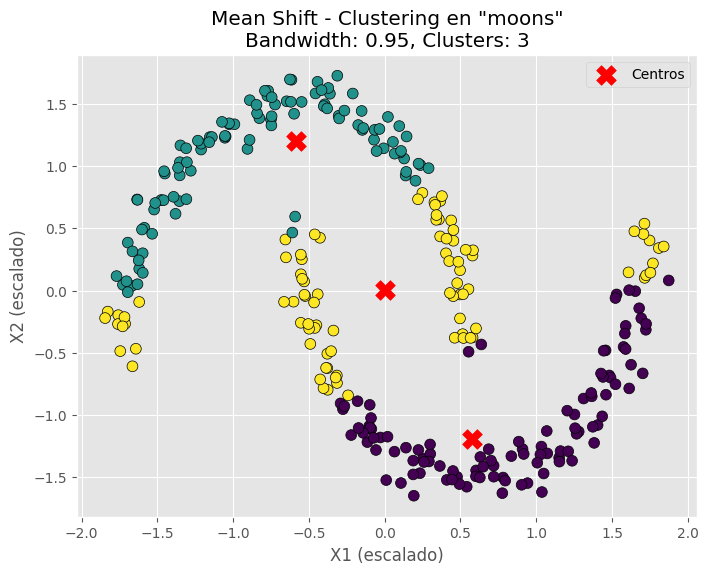

In [ ]:
# 1. Crear datos de medias lunas
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# 2. Escalar los datos (opcional pero recomendado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Estimar el parámetro bandwidth
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2)

# 4. Aplicar Mean Shift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# 5. Visualizar
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=60, edgecolor='k')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label='Centros')
plt.title(f'Mean Shift - Clustering en "moons"\nBandwidth: {bandwidth:.2f}, Clusters: {len(np.unique(labels))}')
plt.xlabel("X1 (escalado)")
plt.ylabel("X2 (escalado)")
plt.legend()
plt.grid(True)
plt.show()